In [3]:
include("src/Models.jl")
include("src/Params.jl")
using Plots
using DifferentialEquations

In [137]:
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]
A0 = 1.0
fATP = 1.0
tau = 5.5

p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M, tau, U0]

tspan = (0.0, 100.0)

prob = ODEProblem(kaiabc_growing!, X0, tspan, p)
sol = solve(prob, Tsit5(), reltol=1e-6, abstol=1e-6);

In [138]:
Xt = reduce(hcat, sol.u)    # states first, time second
pC = 1 .- Xt[1, :]./reshape(sum(Xt, dims=1), :, 1);

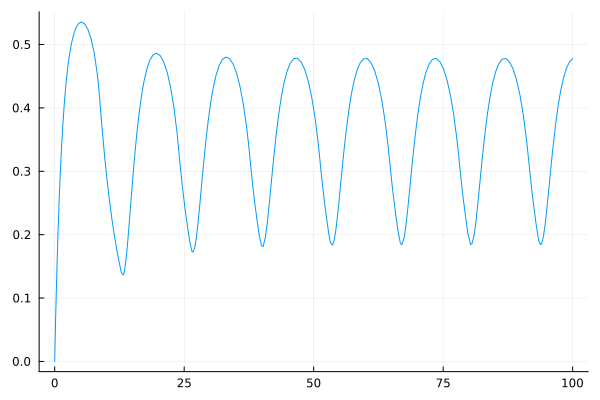

In [139]:
plot(sol.t, pC, leg=false)

In [140]:
function min_indices(X)
    ind_vec = fill(0, length(X))
    n_ind = 0
    for i = 2:length(X) - 1
        if X[i - 1] > X[i] < X[i + 1]
            n_ind += 1
            ind_vec[n_ind] = i
        end
    end
    ind_vec = ind_vec[1:n_ind]
end

min_indices (generic function with 1 method)

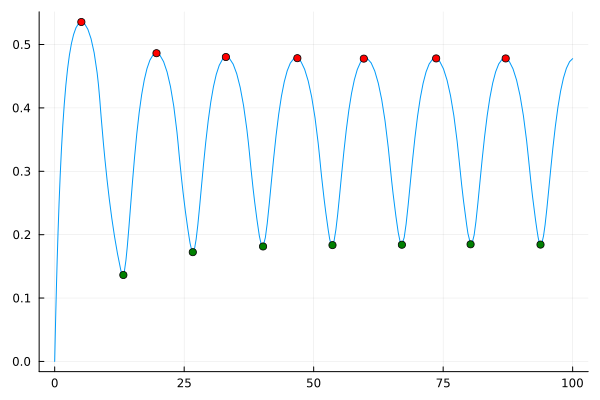

In [141]:
min_ind_vec = min_indices(pC)
max_ind_vec = min_indices(-pC)
scatter!(sol.t[min_ind_vec], pC[min_ind_vec], markercolor=:green)
scatter!(sol.t[max_ind_vec], pC[max_ind_vec], markercolor=:red)

In [158]:
function amp(X)
    # being a continuous function, X = F(t) has to have interleaved min and max
    
    min_ind_vec = min_indices(X)
    max_ind_vec = min_indices(-X)
    n_max = length(max_ind_vec) - 1    # the fewest min there can be
    amp_vec = X[max_ind_vec[1:n_max]] - X[min_ind_vec[1:n_max]]
end

function is_converge(X; conv_len=10, tol=1e-4)
    
    i = 1
    
    while i + conv_len - 1 <= length(X)
        if all(abs.(X[i + 1:i + conv_len - 1] .- X[i]) .< tol)
            return true, i
        else
            i += conv_len
        end
    end
    
    return false, -1
end

function phospho_C(u)
    Xt = reduce(hcat, u)
    pC = 1 .- Xt[1, :]./reshape(sum(Xt, dims=1), :, 1)
end

function attracted_to(f, X0, tmax0, p; tmax_stop=1e4, avg_window=10, amp_cutoff=1e-4)
    converge = false
    tmax = tmax0
    
    while !converge && tmax < tmax_stop
        prob = ODEProblem(f, X0, (0.0, tmax), p)
        sol = solve(prob, reltol=1e-6, abstol=1e-6)
        
        pC = phospho_C(sol.u)
        
        amp_vec = amp(pC)
        
        converge, conv_ind = is_converge(amp_vec, tol=1e-3)
        
        if converge
            amp_mean = sum(amp_vec[conv_ind:conv_ind + avg_window - 1])/avg_window
            if amp_mean < amp_cutoff
                return converge, -1, -1, -1    # stable fixed point
            end
            # otherwise, stable limit cycle
            min_ind_vec = min_indices(pC)
            t_window = sol.t[min_ind_vec[conv_ind:conv_ind + avg_window - 1]]
            per_mean = sum(t_window[2:avg_window] - t_window[1:avg_window - 1])/(avg_window - 1)
            phase = (t_window[1]%per_mean)/per_mean*2π
            #print("converged after time ", t_window[1])
            return converge, amp_mean, per_mean, phase
        else
            tmax *= 2
        end
    end
    
    # not converging. Often attracting to a fixed point/a limit cycle algebraically
    return converge, -1, -1, -1
end

attracted_to (generic function with 1 method)

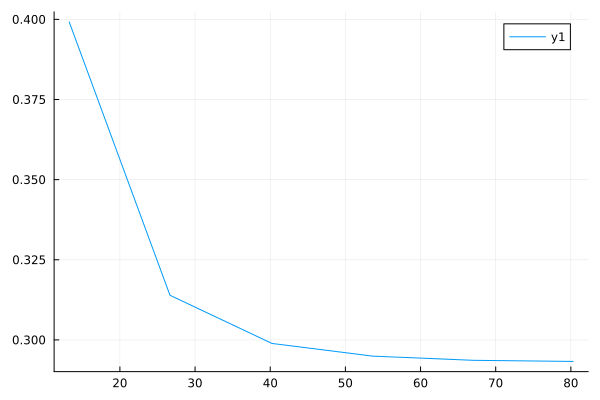

(false, -1)

In [143]:
amp_vec = amp(pC)
min_ind_vec = min_indices(pC)
display(plot(sol.t[min_ind_vec[1:length(amp_vec)]], amp_vec))

is_converge(amp_vec, tol=1e-4)

In [159]:
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]
A0 = 1.0
fATP = 1.0
tau = 6

p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M, tau, U0]

@time attracted_to(kaiabc_growing!, X0, 500, p)

 12.046685 seconds (3.83 M allocations: 739.500 MiB, 6.23% gc time, 10.22% compilation time)


(true, 0.3321380215835122, 13.463410455346738, 0.4708149464260681)